In [9]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(2, 3):
    for att in range(10, 250, 20):
        # Load and compute data
        postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{att}.csv", delimiter=',', dtype=np.int8)
        postread_cer = np.not_equal(postread, [[i % (2**bpc) for i in range(16)]]*65536).mean()
        dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd_dac = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
        energy_tot = power_tot * dt
        bw = 2**16 * 48 * bpc / dt # bits per second
        energy_per_bit = energy_tot / 2**16 / 48 / bpc
        edp = energy_per_bit / bw

        # Load data into confmat
        confmat = np.zeros(shape=(2**bpc, 2**bpc))
        for i in range(65536):
            for j in range(16):
                confmat[j % (2**bpc)][postread[i][j]] += 1
        confmat = confmat.astype(int)
        print(confmat)

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()
        
        # Compose dataframe
        data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": postread_cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[244325    426    317  17076]
 [ 21555 232371    769   7449]
 [  7418   2563 241565  10598]
 [    68     17    333 261726]]
[[243881    581    488  17194]
 [ 11856 241556    577   8155]
 [  5764   3067 240688  12625]
 [    68     18    136 261922]]
[[244071    563    573  16937]
 [ 11132 242639    406   7967]
 [  5085   3267 241413  12379]
 [    69     18    106 261951]]
[[243282    616    612  17634]
 [  9648 244444    269   7783]
 [  4092   3063 242451  12538]
 [    68     19    106 261951]]
[[243129    333    472  18210]
 [  9120 245111    255   7658]
 [  3623   3023 242933  12565]
 [    69     18    102 261955]]
[[242192    287    468  19197]
 [  7479 246769    265   7631]
 [  2866   2565 244144  12569]
 [    68     19     80 261977]]
[[241137    285    481  20241]
 [  6210 248036    241   7657]
 [  2409   2428 245044  12263]
 [    67     19     80 261978]]
[[240333    250    492  21069]
 [  5653 248524    254   7713]
 [  2616   2415 245006  12107]
 [    66     18     89 261971]]


,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,10,2,0.558154821395874,0.019655,1.743710e-09,1.546956e-16,1.127188e+07,0.065412,0.039954,0.112608,0.489592
1,30,2,0.7113656997680664,0.021869,2.472661e-09,2.795801e-16,8.844194e+06,0.057725,0.035741,0.104406,0.480306
2,50,2,0.8862709999084473,0.022834,3.216619e-09,4.531219e-16,7.098795e+06,0.055792,0.034401,0.101239,0.473888
3,70,2,1.0612075328826904,0.023038,3.885993e-09,6.554675e-16,5.928582e+06,0.053833,0.032880,0.099524,0.473992
4,90,2,1.2313849925994873,0.023151,4.531096e-09,8.868414e-16,5.109252e+06,0.052879,0.032053,0.098969,0.475409
5,110,2,1.4086604118347168,0.023861,5.342385e-09,1.196163e-15,4.466269e+06,0.051016,0.030746,0.098236,0.478980
6,130,2,1.5869147777557373,0.023652,5.965697e-09,1.504748e-15,3.964583e+06,0.049954,0.030015,0.098765,0.484894
7,150,2,1.7656147480010986,0.024970,7.007374e-09,1.966528e-15,3.563323e+06,0.050299,0.030318,0.100947,0.492500
8,170,2,1.9388611316680908,0.024749,7.626859e-09,2.350397e-15,3.244923e+06,0.050676,0.030518,0.102866,0.499075
9,190,2,2.104612350463867,0.024481,8.189438e-09,2.739524e-15,2.989366e+06,0.050982,0.030688,0.104595,0.505014


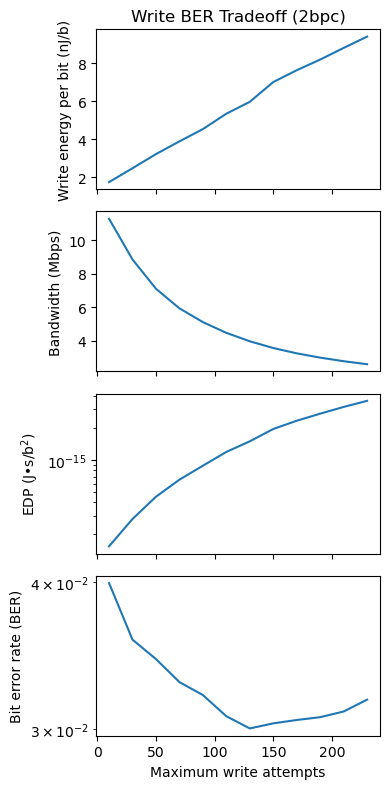

In [16]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()

## Experiments part

In [12]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data/"
for fname in glob.glob(f"{datadir}/dt_*.csv"):
    # Extract info from filename
    _, _, bpc, lvl, expt, att = fname[:-4].split('_')[-6:]
    bpc, lvl, expt, att = int(bpc[0]), int(lvl[3:]), int(expt), int(att)

    # Load and compute data
    try:
        postread = np.loadtxt(fname.replace("dt", "postread"), delimiter=',', dtype=np.int8)
        dt = np.loadtxt(fname, delimiter=',')
        ivdd = np.loadtxt(fname.replace("dt", "vdd_power"), delimiter=',')
        ivdd_dac = np.loadtxt(fname.replace("dt", "vdd_dac_power"), delimiter=',')
        ivsa = np.loadtxt(fname.replace("dt", "vsa_power"), delimiter=',')
        ivddio = np.loadtxt(fname.replace("dt", "vddio_power"), delimiter=',')
        ivddio_dac = np.loadtxt(fname.replace("dt", "vddio_dac_power"), delimiter=',')
    except OSError:
        continue
    postread_cer = (postread != lvl).mean()
    power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
    energy_tot = power_tot * dt
    bw = 2**16 * 48 * bpc / dt # bits per second
    energy_per_bit = energy_tot / 2**16 / 48 / bpc
    edp = energy_per_bit / bw

    # Confusion vector
    confvec = np.unique(postread, return_counts=True)
    print(confvec)

    # Compose dataframe
    data.append({"att": att, "bpc": bpc, "lvl": lvl, "expt": expt, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": postread_cer})
data = pd.DataFrame(data)
data

(array([0, 1, 2, 3], dtype=int8), array([33409, 91796,  2733,  3134]))
(array([0, 1, 2, 3], dtype=int8), array([53997, 66651,  5252,  5172]))
(array([0, 1, 2, 3], dtype=int8), array([29911,  5143, 88019,  7999]))
(array([0, 1, 2, 3], dtype=int8), array([21162, 98041,  9833,  2036]))
(array([0, 1, 2, 3], dtype=int8), array([26738,  1928, 93749,  8657]))
(array([0, 1, 2, 3], dtype=int8), array([29606,  3372, 92598,  5496]))
(array([0, 1, 2, 3], dtype=int8), array([17392, 16347, 90992,  6341]))
(array([0, 1, 2, 3], dtype=int8), array([ 14469,   1576, 111035,   3992]))
(array([0, 1, 2, 3], dtype=int8), array([32924,  2205, 87262,  8681]))
(array([0, 1, 2, 3], dtype=int8), array([30650,  6819, 83376, 10227]))
(array([0, 1, 2, 3], dtype=int8), array([38207,  4459, 81381,  7025]))
(array([0, 1, 2, 3], dtype=int8), array([37591, 79937,  9610,  3934]))
(array([0, 1, 2, 3], dtype=int8), array([28707,  2795, 91756,  7814]))
(array([0, 1, 2, 3], dtype=int8), array([44027,  2797, 75589,  8659]))
(a

,att,bpc,lvl,expt,dt,power_tot,energy_per_bit,edp,bw,cer
0,50,2,1,10,0.7182419300079346,0.036717,4.191641e-09,4.785240e-16,8.759522e+06,0.299652
1,50,2,1,20,0.6730413436889648,0.041317,4.419928e-09,4.728309e-16,9.347800e+06,0.491493
2,130,2,2,14,1.2221715450286865,0.037487,7.282122e-09,1.414617e-15,5.147768e+06,0.328468
3,210,2,1,16,1.9900124073028564,0.038204,1.208398e-08,3.822212e-15,3.161516e+06,0.252007
4,130,2,2,52,1.136540174484253,0.043713,7.896609e-09,1.426508e-15,5.535621e+06,0.284752
...,...,...,...,...,...,...,...,...,...,...
877,250,2,2,16,2.919128656387329,0.043890,2.036427e-08,9.448675e-15,2.155251e+06,0.326073
878,10,2,1,16,0.12293624877929688,0.037772,7.380765e-10,1.442216e-17,5.117657e+07,0.379959
879,50,2,1,28,0.6469097137451172,0.046662,4.797994e-09,4.933467e-16,9.725400e+06,0.495575
880,130,2,2,25,1.602135419845581,0.046611,1.186971e-08,3.022651e-15,3.926919e+06,0.446358


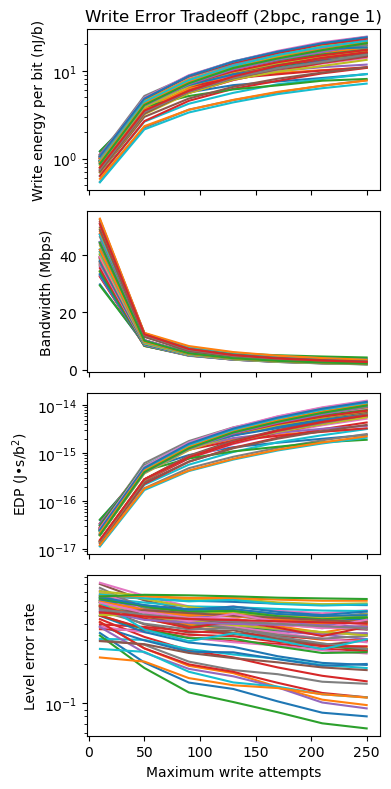

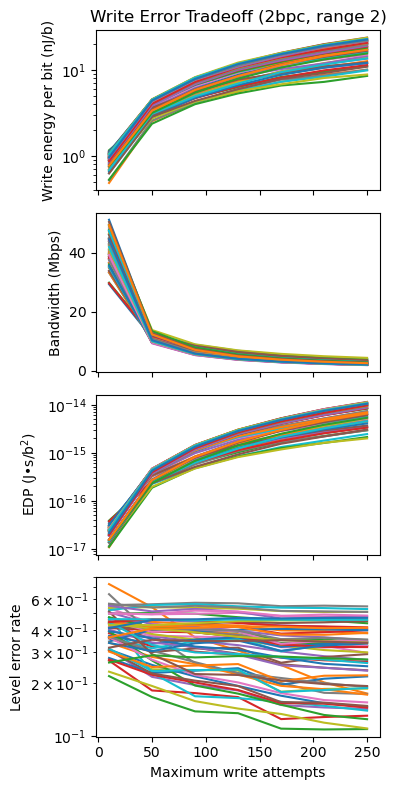

In [13]:
# Plot write BER tradeoff vs. attempts
for (bpc, lvl), d2 in data.groupby(["bpc", "lvl"]):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    for expt, d in d2.sort_values("att").groupby("expt"):
        axs[0].set_title(f"Write Error Tradeoff ({bpc}bpc, range {lvl})")
        axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
        axs[0].set_yscale("log")
        axs[0].set_ylabel("Write energy per bit (nJ/b)")
        axs[1].plot(d["att"], d["bw"]/1e6)
        # axs[1].set_yscale("log")
        axs[1].set_ylabel("Bandwidth (Mbps)")
        axs[2].plot(d["att"], d["edp"])
        axs[2].set_yscale("log")
        axs[2].set_ylabel("EDP (J•s/b$^2$)")
        axs[3].plot(d["att"], d["cer"])
        axs[3].set_yscale("log")
        axs[3].set_ylabel("Level error rate")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_lvl{lvl}_opt_write_tradeoff.pdf")
    plt.show()